# PRIM on the Hamarat et al. 2013 Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import ema_logging, load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis.prim import pca_preprocess, Prim
from ema_workbench.analysis.cart import CART
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from clean_hamarat import clean_results
from src.config.paths import HAMARAT_DATA_DIR

## Load and Clean the Data

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

In [3]:
print(X)

     SWITCH_Market_price_determination SWITCH_TGC_obligation_curve  \
0                                    2                           3   
1                                    1                           2   
2                                    2                           3   
3                                    2                           1   
4                                    1                           3   
...                                ...                         ...   
9995                                 2                           1   
9996                                 1                           2   
9997                                 1                           3   
9998                                 2                           2   
9999                                 2                           1   

     SWITCH_carbon_cap SWITCH_carbon_price_determination  \
0                    3                                 2   
1                    2                 

 ## Plot the Data

Figure saved: renewables_over_time_0_6_threshold.pdf


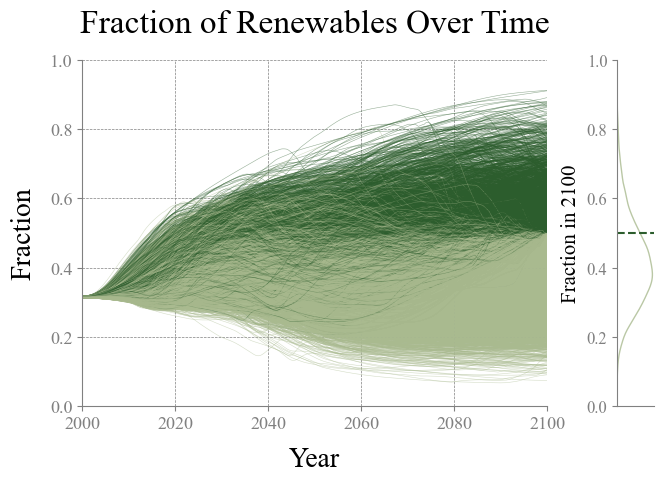


At threshold the threshold of 50.0% renewables by 2100:
22.8% of cases exceed threshold (2281 of 10000), 77.2% of cases below threshold (7719 of 10000)


In [4]:
plot_fraction_renewables(outcomes, threshold=0.5, save_path="renewables_over_time_0_6_threshold.pdf")

## Set Binary Threshold for y

In [5]:
threshold_value = 0.6  # for example
y = (y_continuous > threshold_value).astype(int)

In [6]:
# Convert categorical variables to dummy variables
categorical_cols = [col for col in X.columns if str(X[col].dtype) == 'category']
X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Changed categorical variables to dummy variables making the experiments Dataframe gain {X_dummy.shape[1]-X.shape[1]} columns.")

Changed categorical variables to dummy variables making the experiments Dataframe gain 22 columns.


In [7]:
# # Drop SWITCH columns, as they are not needed for the analysis
# switch_cols = [col for col in X_encoded.columns if col.startswith("SWITCH")]
# X_encoded = X_encoded.drop(columns=switch_cols)

## Applying Extra Trees Feature Scoring to Determine Features of Interest

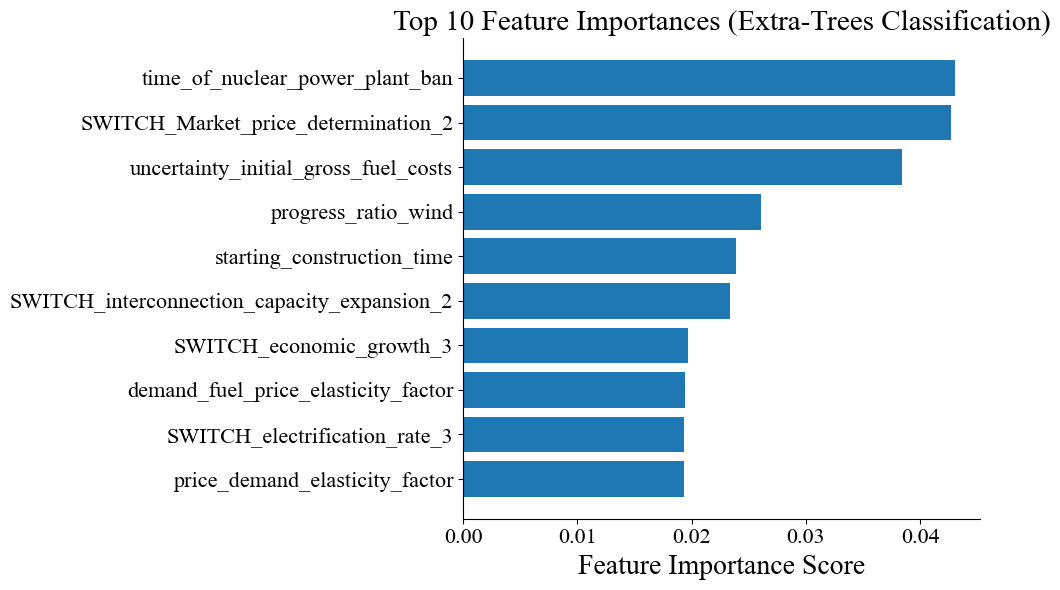

In [8]:
feature_scores_class, model_class = get_ex_feature_scores(
    x=X_dummy,
    y=y,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=None,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    oob_score=True,
    random_state=42
)

top_n = 10
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Feature Importances (Extra-Trees Classification)')
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

# Applying PRIM

In [9]:
# === Run PRIM analysis ===
prim_alg = Prim(X, y, threshold=0.2)
box = prim_alg.find_box()

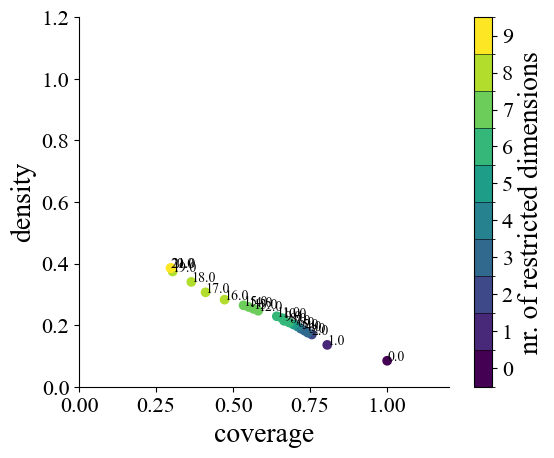

In [10]:
# === Plot trade-off curve ===
box.show_tradeoff(annotated=True)
plt.show()

coverage       0.533808
density        0.264395
id            15.000000
k            450.000000
mass           0.170200
mean           0.264395
n           1702.000000
res_dim        7.000000
Name: 15, dtype: float64

                                                    box 15                   \
                                                       min              max   
progress_ratio_wind                               0.850014         0.978228   
starting_construction_time                        0.100009          2.69255   
time_of_nuclear_power_plant_ban                2013.000592      2096.109909   
SWITCH_Market_price_determination                      {1}              {1}   
SWITCH_interconnection_capacity_expansion        {1, 2, 3}        {1, 2, 3}   
uncertainty_initial_gross_fuel_costs              0.765241         1.499997   
SWITCH_economic_growth                     {1, 2, 3, 4, 5}  {1, 2, 3, 4, 5}   

                                                                   
  

C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\.venv\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\.venv\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


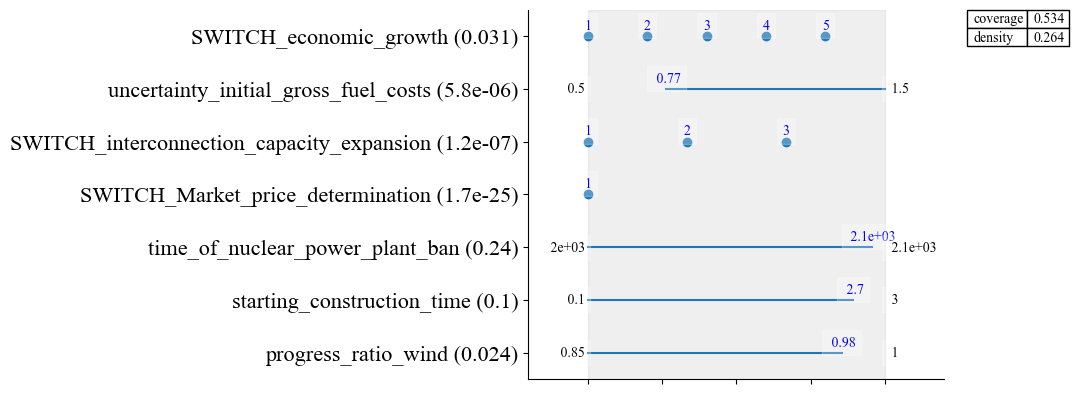

In [12]:
# === Inspect a chosen box ===
chosen_box = 15
box.inspect(chosen_box)                 # Table
box.inspect(chosen_box, style="graph")  # Graph
plt.show()

In [ ]:
# === Show pairwise scatter for restricted dimensions ===
box.select(chosen_box)
box.show_pairs_scatter()
plt.show()

# Running PCA-PRIM

In [ ]:
# PCA preprocessing to rotate the space
X_pca, pca_matrix = pca_preprocess(X_df, y_array)

In [ ]:
# Now run PRIM in PCA space (this is PCA-PRIM)
pca_prim = Prim(X_pca, y_array, threshold=0.8)
box = pca_prim.find_box()

In [ ]:
box.show_tradeoff(annotated=True)
plt.show()

In [ ]:
chosen_box_pca_prim = 4 # Select box 4 for further analysis

box.inspect(chosen_box_pca_prim)                  # textual
box.inspect(chosen_box_pca_prim, style="graph")   # graphical
plt.show()

In [ ]:
box.select(chosen_box_pca_prim)
box.show_pairs_scatter()
plt.show()

# Running CART

In [ ]:
def get_predicted_label_for_each_box(cart_model: CART):
    """Returns the predicted class for each terminal box (leaf)."""
    clf = cart_model.clf
    values = clf.tree_.value  # shape (n_nodes, 1, n_classes)
    classes = clf.classes_
    is_leaf = clf.tree_.children_left == -1

    labels = []
    for i in range(len(is_leaf)):
        if is_leaf[i]:
            class_counts = values[i][0]
            predicted_class = classes[np.argmax(class_counts)]
            labels.append(predicted_class)
    return labels


def compute_cart_coverage_density(cart_model: CART, X_df, y_array, positive_class=1):
    boxes = cart_model.boxes
    labels = get_predicted_label_for_each_box(cart_model)

    total_positive = np.sum(y_array == positive_class)
    mask_union = np.zeros(len(X_df), dtype=bool)

    for box, label in zip(boxes, labels):
        if label != positive_class:
            continue
        mask = sdutil._in_box(X_df, box)
        mask_union |= mask

    selected_y = y_array[mask_union]
    coverage = np.sum(selected_y == positive_class) / total_positive if total_positive > 0 else 0
    density = np.sum(selected_y == positive_class) / len(selected_y) if len(selected_y) > 0 else 0

    return coverage, density


# === Sweep mass_min values ===
mass_min_values = np.linspace(0.01, 0.1, 20)
coverages = []
densities = []

for mass_min in mass_min_values:
    cart_model = CART(X_df, y_array, mass_min=mass_min)
    cart_model.build_tree()
    coverage, density = compute_cart_coverage_density(cart_model, X_df, y_array)
    coverages.append(coverage)
    densities.append(density)

# === Plotting ===
plt.figure(figsize=(4.7, 3.7))
plt.plot(mass_min_values, coverages, label="Coverage", marker='o')
plt.plot(mass_min_values, densities, label="Density", marker='s')
plt.ylim(0, 1)
plt.xlabel("mass_min")
plt.ylabel("Metric Value")
plt.title("Coverage and Density vs. CART mass_min")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === Run CART ===
cart_alg = CART(X_df, y_array, mass_min=0.05)
cart_alg.build_tree()

# === Print stats and box limits ===
print("CART Box Stats:")
print(pd.DataFrame(cart_alg.stats))

In [ ]:
def get_predicted_label_for_each_box(cart_model: CART):
    """Returns a list of predicted labels for each terminal leaf box."""
    clf = cart_model.clf
    values = clf.tree_.value  # shape (n_nodes, 1, n_classes)
    classes = clf.classes_    # class labels (e.g., [0, 1])

    left = clf.tree_.children_left
    is_leaf = left == -1

    labels = []
    for i in range(len(is_leaf)):
        if is_leaf[i]:
            class_counts = values[i][0]
            predicted_class = classes[np.argmax(class_counts)]
            labels.append(predicted_class)
    return labels

In [ ]:
def compute_cart_coverage_density(cart_model: CART, X_df, y_array, positive_class=1):
    boxes = cart_model.boxes
    stats = cart_model.stats
    labels = get_predicted_label_for_each_box(cart_model)

    total_positive = np.sum(y_array == positive_class)
    mask_union = np.zeros(len(X_df), dtype=bool)

    for box, label in zip(boxes, labels):
        if label != positive_class:
            continue
        mask = sdutil._in_box(X_df, box)
        mask_union |= mask

    selected_y = y_array[mask_union]

    coverage = np.sum(selected_y == positive_class) / total_positive if total_positive > 0 else 0
    density = np.sum(selected_y == positive_class) / len(selected_y) if len(selected_y) > 0 else 0

    return coverage, density

In [ ]:
cart_alg = CART(X_df, y_array, mass_min=0.05)
cart_alg.build_tree()

coverage, density = compute_cart_coverage_density(cart_alg, X_df, y_array)
print(f"Coverage: {coverage:.3f}")
print(f"Density: {density:.3f}")